In [3]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import tensorflow as tf
%matplotlib inline

In [4]:
df = pd.read_csv('stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
df.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


## Data Exploration


In [5]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

10286120

We have over 10 million words in the data.

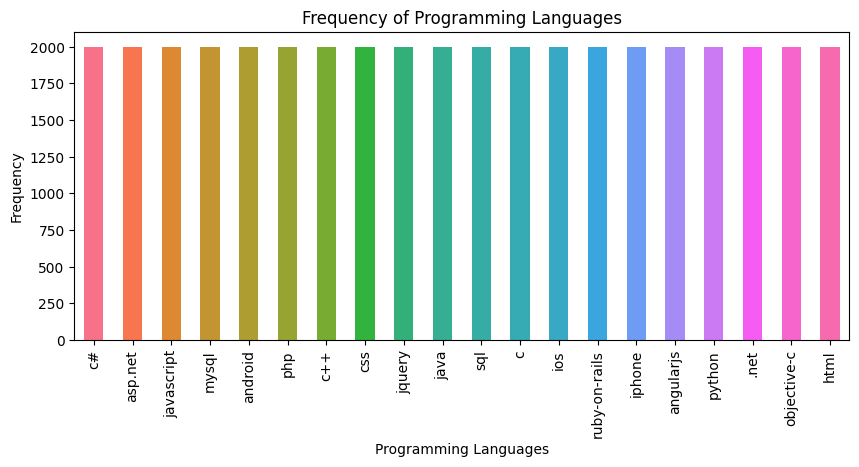

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your list of programming languages
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']

# Generate a color palette with as many colors as there are categories
# You can choose a suitable palette from Seaborn or create your custom one
color_palette = sns.color_palette("husl", len(my_tags))

# Plot the bar chart with the specified color palette
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar', color=color_palette)

# Customize the plot labels and title as needed
plt.xlabel("Programming Languages")
plt.ylabel("Frequency")
plt.title("Frequency of Programming Languages")

# Show the plot
plt.show()

The classes are very well balanced

In [7]:
def print_plot(index):
  # Find the example with the specified index
  example = df[df.index == index][['post', 'tags']].values[0]
  # Check if the example exists
  if len(example) > 0:
    # Print the text content
    print(example[0])
    # Print the associated tag
    print("Tag:", example[1])

Have a look a few post and tag pairs

> Indented block



In [8]:
print_plot(10)

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it
Tag:

In [9]:
print_plot(30)

how to chain expressions inside ngclass when using the {...}[] form  how can i add another expression to an <code>ng-class</code> directive that uses this form:   <pre><code>ng-class= {true: loading   false: loading-done }[data.loader===null]  </code></pre>   i d like to add something like this to the list:   <pre><code>{highlight:isspecial} </code></pre>   is it possible without expanding the first expression     thanks.
Tag: angularjs


In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Regular expression pattern that matches certain symbols, including "/(){}[]|@,;"
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# Regular expression pattern that matches any character that is not a lowercase letter, digit, space, "#, +, or _"
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding, removing any HTML tags & converting HTML entities to their corresponding characters
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [12]:
# Using clean_text function to preprocess text data
df['post'] = df['post'].apply(clean_text)

<ipython-input-11-d9774f746e77>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding, removing any HTML tags & converting HTML entities to their corresponding characters


In [13]:
print_plot(30)

chain expressions inside ngclass using form add another expression ngclass directive uses form ngclass true loading false loadingdone dataloadernull like add something like list highlightisspecial possible without expanding first expression thanks
Tag: angularjs


In [14]:
# Split each text in the "post" column into words based on spaces (' '), and then sum up the word count for all the posts
df['post'].apply(lambda x : len(x.split(' '))).sum()

3424155

Now we have over 3 million words to work with

In [15]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers

## Naive Bayes classifier for multinomial models

In [16]:
'''
 Building a text classification pipeline using scikit-learn
 The Pipeline class in scikit-learn is used to chain together multiple processing steps into a single estimator.
 In this case, the Pipeline named 'nb' starts with tokenization and vectorization using CountVectorizer,
 followed by TF-IDF transformation using TfidfTransformer, and ends with the Multinomial Naive Bayes classifier
'''
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [17]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7394166666666667
               precision    recall  f1-score   support

         java       0.63      0.65      0.64       613
         html       0.94      0.86      0.90       620
      asp.net       0.87      0.92      0.90       587
           c#       0.70      0.77      0.73       586
ruby-on-rails       0.73      0.87      0.79       599
       jquery       0.72      0.51      0.60       589
        mysql       0.77      0.74      0.75       594
          php       0.69      0.89      0.78       610
          ios       0.63      0.59      0.61       617
   javascript       0.57      0.65      0.60       587
       python       0.70      0.50      0.59       611
            c       0.79      0.79      0.79       594
          css       0.84      0.59      0.69       619
      android       0.65      0.84      0.74       574
       iphone       0.64      0.83      0.72       584
          sql       0.66      0.64      0.65       578
  objective-c       0.79      0.77  

## Linear support vector machine

In [18]:
from sklearn.linear_model import SGDClassifier

# The hinge loss is designed to maximize the margin between classes in the feature space
# L2 adds a penalty term to the loss function that discourages large coefficients, helping to prevent overfitting
# L2 regularization is effective when there are many features (high-dimensional data)
# alpha parameter controls the strength of regularization. A smaller value of alpha increases regularization strength, while a larger value reduces it
# tol parameter sets tolerance for stopping criterion during training
#If change in the loss function between consecutive iterations falls below this tolerance, training is terminated early

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [19]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.78975
               precision    recall  f1-score   support

         java       0.74      0.67      0.70       613
         html       0.84      0.94      0.89       620
      asp.net       0.88      0.95      0.92       587
           c#       0.81      0.80      0.80       586
ruby-on-rails       0.73      0.88      0.80       599
       jquery       0.78      0.39      0.52       589
        mysql       0.81      0.68      0.74       594
          php       0.71      0.95      0.81       610
          ios       0.83      0.56      0.67       617
   javascript       0.72      0.58      0.64       587
       python       0.71      0.66      0.68       611
            c       0.80      0.88      0.83       594
          css       0.77      0.79      0.78       619
      android       0.84      0.86      0.85       574
       iphone       0.82      0.81      0.81       584
          sql       0.71      0.68      0.69       578
  objective-c       0.81      0.90      0.85   

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                   ])
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [21]:
%%time
y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.7813333333333333
               precision    recall  f1-score   support

         java       0.67      0.63      0.65       613
         html       0.92      0.90      0.91       620
      asp.net       0.98      0.94      0.96       587
           c#       0.75      0.75      0.75       586
ruby-on-rails       0.77      0.83      0.80       599
       jquery       0.61      0.57      0.59       589
        mysql       0.77      0.76      0.76       594
          php       0.83      0.86      0.84       610
          ios       0.68      0.73      0.70       617
   javascript       0.59      0.59      0.59       587
       python       0.64      0.63      0.64       611
            c       0.83      0.82      0.82       594
          css       0.77      0.77      0.77       619
      android       0.86      0.84      0.85       574
       iphone       0.82      0.84      0.83       584
          sql       0.66      0.66      0.66       578
  objective-c       0.83      0.82  

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List files in your google drive
import os

# Define the path to your Google Drive folder
drive_path = '/content/drive/My Drive/'

# List files in the specified directory
file_list = os.listdir(drive_path)

# Print the list of files
for file in file_list:
    print(file)


In [23]:
file = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'

## Word2vec embedding and Logistic Regression

In [24]:
%%time
from gensim.models import word2vec
wv = gensim.models.KeyedVectors.load_word2vec_format(file, binary=True)
wv.init_sims(replace=True)

<timed exec>:3: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).


CPU times: user 23.5 s, sys: 3.67 s, total: 27.2 s
Wall time: 27.2 s


In [25]:
from itertools import islice
# Get a list of words using index_to_key
word_list = list(islice(wv.index_to_key, 13030, 13050))

# Print the list of words
print(word_list)

['Memorial_Hospital', 'Seniors', 'memorandum', 'elephant', 'Trump', 'Census', 'pilgrims', 'De', 'Dogs', '###-####_ext', 'chaotic', 'forgive', 'scholar', 'Lottery', 'decreasing', 'Supervisor', 'fundamentally', 'Fitness', 'abundance', 'Hold']


The common way is to average the two word vectors. BOW based approaches which includes averaging

In [26]:
'''
The function iterates through the input words, and if a word is represented as a NumPy array (a word vector), it appends the vector
to the mean list. If the word is in the vocabulary of the word embedding model, it retrieves the word's vector and appends it to mean.
After processing all words, it calculates the mean of the word vectors and returns it as a NumPy array
'''
def word_averaging(wv, words):
    all_words, mean = set(), []

    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.get_normed_vectors()[wv.key_to_index[word]])
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

'''
The function applies word_averaging to each document in text_list, resulting in a list of averaged word vectors for each document.
It then vertically stacks these averaged word vectors into a NumPy array,
creating a matrix where each row represents a document and each column represents a feature (word embedding dimension)
'''

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [27]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and test sets
train, test = train_test_split(df, test_size=0.3, random_state=42)

# Tokenize the text data in both training and test sets
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

# Flatten the list of tokenized words for each document
train_tokenized_flat = [' '.join(tokens) for tokens in train_tokenized]
test_tokenized_flat = [' '.join(tokens) for tokens in test_tokenized]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data using TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(train_tokenized_flat)

# Transform the test data using the same TF-IDF model
X_test_tfidf = tfidf_vectorizer.transform(test_tokenized_flat)

# Define the desired number of dimensions (e.g., 100)
num_dimensions = 50

# Create an instance of TruncatedSVD
svd = TruncatedSVD(n_components=num_dimensions, random_state=42)

# Fit and transform the training data using TruncatedSVD
X_train_word_average_reduced = svd.fit_transform(X_train_tfidf)

# Transform the test data using the same TruncatedSVD model
X_test_word_average_reduced = svd.transform(X_test_tfidf)

In [ ]:
X_train_word_average = word_averaging_list(wv, X_train_word_average_reduced)
X_test_word_average = word_averaging_list(wv, X_test_word_average_reduced)

In [31]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

In [32]:
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

accuracy 0.04783333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

         java       0.00      0.00      0.00       613
         html       0.00      0.00      0.00       620
      asp.net       0.00      0.00      0.00       587
           c#       0.00      0.00      0.00       586
ruby-on-rails       0.00      0.00      0.00       599
       jquery       0.00      0.00      0.00       589
        mysql       0.00      0.00      0.00       594
          php       0.00      0.00      0.00       610
          ios       0.00      0.00      0.00       617
   javascript       0.00      0.00      0.00       587
       python       0.00      0.00      0.00       611
            c       0.00      0.00      0.00       594
          css       0.00      0.00      0.00       619
      android       0.05      1.00      0.09       574
       iphone       0.00      0.00      0.00       584
          sql       0.00      0.00      0.00       578
  objective-c       0.00      0.00      0.00       591
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Doc2vec and Logistic Regression


Doc2vec, taking the linear combination of every term in the document creates a random walk with bias process in the word2vec space

In [33]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [38]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Define a function to label sentences/documents
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(words=v.split(), tags=[label]))
    return labeled

# Now you can use the label_sentences function
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

# Create and train a Doc2Vec model
model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=4, epochs=10)
model.build_vocab(all_data)
model.train(all_data, total_examples=model.corpus_count, epochs=model.epochs)

In [39]:
all_data[:2]

[TaggedDocument(words=['getting', 'server', 'tag', 'well', 'formed', 'error', 'th', 'style', 'width200px', 'aspcheckbox', 'id', 'utilitychanged', '#', 'eval', 'id', 'runat', 'server', 'enabled', 'true', 'onchange', 'utilitychanged', '#', 'eval', 'id', 'checked', '#', 'converttoboolean', 'eval', 'checked', 'th', 'error', 'server', 'tag', 'well', 'formedi', 'cant', 'seem', 'debug', 'itany', 'help', 'guys', 'edit', 'commented', 'ochange', 'still', 'getting', 'error', 'directly', 'code', 'binding', 'different', 'field', 'using', 'datasource', 'works', 'fine', 'th', 'style', 'width200px', '#', 'eval', 'name', 'th', 'doesnt', 'work', 'th', 'style', 'width200px', 'aspcheckbox', 'id', 'utilitychanged#', 'eval', 'id', 'runat', 'server', 'enabled', 'true', 'checked', '#', 'converttoboolean', 'eval', 'checked', 'th'], tags=['Train_0']),
 TaggedDocument(words=['difference', 'lineheight15', 'lineheight150', 'css', 'anyone', 'knows'], tags=['Train_1'])]

In [40]:
for epoch in range(30):
    model.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model.alpha -= 0.002
    model.min_alpha = model.alpha

100%|██████████| 40000/40000 [00:00<00:00, 3346074.19it/s]


In [41]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [42]:
train_vectors_dbow = get_vectors(model, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model, len(X_test), 300, 'Test')

<ipython-input-41-c807116ba1f2>:13: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


In [43]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100000.0, n_jobs=1)

In [44]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6848333333333333
               precision    recall  f1-score   support

         java       0.53      0.54      0.53       613
         html       0.78      0.81      0.79       620
      asp.net       0.82      0.83      0.83       587
           c#       0.62      0.64      0.63       586
ruby-on-rails       0.78      0.80      0.79       599
       jquery       0.57      0.58      0.57       589
        mysql       0.73      0.72      0.73       594
          php       0.72      0.73      0.73       610
          ios       0.58      0.58      0.58       617
   javascript       0.55      0.52      0.53       587
       python       0.53      0.51      0.52       611
            c       0.72      0.71      0.72       594
          css       0.70      0.69      0.69       619
      android       0.72      0.75      0.73       574
       iphone       0.66      0.63      0.64       584
          sql       0.57      0.57      0.57       578
  objective-c       0.78      0.76  

### BOW with Keras

In [46]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [47]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 28000
Test size: 12000


In [48]:
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

In [57]:
max_words = 1500
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [58]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [59]:
# Using the LabelEncoder from scikit-learn to encode your target labels in the train_tags and test_tags variables
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [60]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [61]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (28000, 1500)
x_test shape: (12000, 1500)
y_train shape: (28000, 20)
y_test shape: (12000, 20)


In [62]:
batch_size = 32
epochs = 6

In [63]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [64]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/6
788/788 [==============================] - 3s 3ms/step - loss: 0.9942 - accuracy: 0.7256 - val_loss: 0.6296 - val_accuracy: 0.8096
Epoch 2/6
788/788 [==============================] - 2s 3ms/step - loss: 0.5157 - accuracy: 0.8361 - val_loss: 0.6251 - val_accuracy: 0.8114
Epoch 3/6
788/788 [==============================] - 2s 3ms/step - loss: 0.3977 - accuracy: 0.8707 - val_loss: 0.6524 - val_accuracy: 0.8014
Epoch 4/6
788/788 [==============================] - 2s 3ms/step - loss: 0.3088 - accuracy: 0.9001 - val_loss: 0.6855 - val_accuracy: 0.8007
Epoch 5/6
788/788 [==============================] - 2s 3ms/step - loss: 0.2451 - accuracy: 0.9202 - val_loss: 0.7235 - val_accuracy: 0.7943
Epoch 6/6
788/788 [==============================] - 2s 3ms/step - loss: 0.1932 - accuracy: 0.9392 - val_loss: 0.7597 - val_accuracy: 0.7950


In [65]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

375/375 [==============================] - 1s 2ms/step - loss: 0.7659 - accuracy: 0.7870
Test accuracy: 0.7870000004768372
